In [83]:
import os
import numpy as np
import pandas as pd
import thunder as td
import matplotlib.pyplot as plt
import prairieModulesa
from glob import glob
import tifffile as tff
from skimage import measure
from matplotlib.path import Path
from skimage.io import imsave


In [163]:
imgPath = '/Users/zhengj10/Desktop/4Hz-250-001/'
# imgPath = '/Volumes/genie/Jihong_GENIE_stuff/flyb_A75-7_20190923-002'


# 'genie⁩ ▸ ⁨Jihong_GENIE_stuff⁩ ▸ ⁨Fly_imaging⁩ ▸ ⁨fly1_A75-2_20190913-001⁩'

os.path.exists(imgPath)


True

In [ ]:
"""
xml file: time stamp of images
csv file: time stamp of voltage output
"""
imgFiles = glob(imgPath + '*.tif')
xmlFiles = glob(imgPath + '*.xml')
csvFiles = glob(imgPath + '*.csv')
imgFiles = sorted(imgFiles)
xmlFiles = sorted(xmlFiles)
csvFiles = sorted(csvFiles) 
print(imgFiles[0])
print(xmlFiles[0])
print(csvFiles[1]) # csvFile index is 0 for 300 ms protocol


### Plot:
- voltage recording
- Photodiode recording
- voltage pulse peak (to confirm no_pulses is correct)

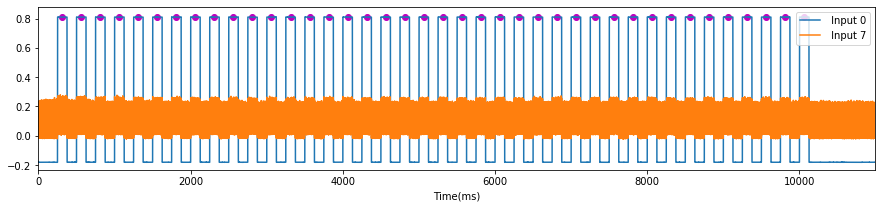

In [145]:
delay = 250
pulse_duration = 125
interval = 125
no_pulses = 40

# delay = 1000
# pulse_duration = 300
# interval = 300
# no_pulses = 100


cycle_duration = pulse_duration + interval
df = pd.read_csv(csvFiles[1])
# df.iloc[:2000].plot(kind='line', x = 'Time(ms)', y = [' Input 0'])
df.plot(kind='line', x = 'Time(ms)', y = [' Input 0', ' Input 7'], figsize=(15,3))
x = []
y = []
for i in range(no_pulses):
    x.append(delay + pulse_duration/2.0 + i*cycle_duration)
    y.append(0.81)
plt.scatter(x,y,color='m')    
# plt.xlim([0,1000])
# plt.xlim([55000,61500])
# plt.xlim([9000,11000])
plt.show()


- images time stamp

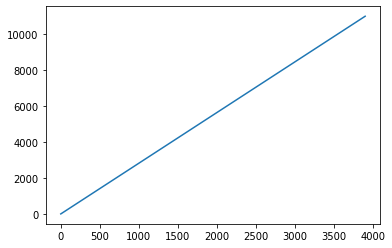

In [146]:
f_tstamp = prairieModules.getTime(xmlFiles[0])
f_tstamp = np.array(f_tstamp[0], dtype=np.float64)
f_tstamp = f_tstamp*1000
f_tstamp = f_tstamp[:21974]
plt.plot(f_tstamp) # Straigt line confirms the time stamp intervals are consistant
plt.show()


In [147]:
f_tstamp[0]-f_tstamp[1]


-2.821622

### Align images with voltage pulses

In [148]:
def align_FV(f_tstamp, delay = 250, pulse_duration = 125, interval = 125, no_pulses=40):
    indexes = []
    cycle_duration = pulse_duration + interval
    for pulse_no in range(no_pulses):
        pulse_end = delay + pulse_duration + pulse_no*cycle_duration
        idx = (np.abs(f_tstamp - pulse_end)).argmin()
        indexes.append(idx)
    return indexes


In [149]:
indexes = align_FV(f_tstamp, delay=delay, pulse_duration=pulse_duration, interval=interval, no_pulses=no_pulses)


### Find rois

- Plot mean image

In [150]:
imgFile = tff.TiffFile(imgFiles[0])
imgFile = imgFile.asarray()


In [151]:
imgFile.shape

(3899, 32, 256)

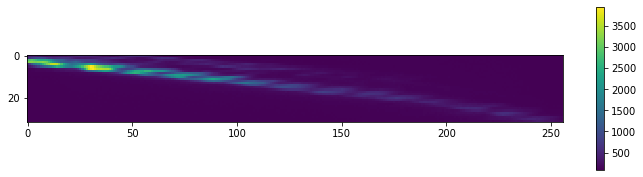

In [152]:
plt.figure(figsize=[12,3])
mean_image = np.mean(imgFile, axis = 0)
plt.imshow(mean_image)
plt.colorbar()
plt.show()


- Creat a binary image with 0.6 x max value of mean image

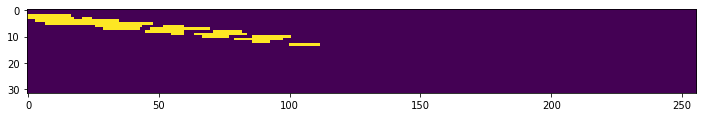

In [153]:
thre = 0.3*np.max(mean_image)
bin_image = mean_image>thre
bin_image = bin_image.astype(int)
plt.figure(figsize=[12,3])
plt.imshow(bin_image)
plt.show()


- Plot contours based on binary image

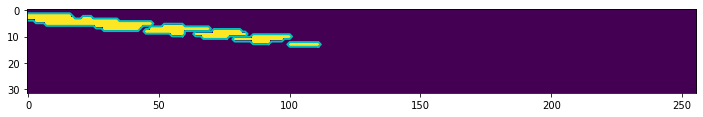

In [154]:
plt.figure(figsize=[12,3])
plt.imshow(bin_image)
contours = measure.find_contours(bin_image, 0.1)
thre = 17 # Exclude small ROIs
roi = 0
for contour in contours:
    if contour.shape[0]>thre:
        roi+=1
        plt.plot(contour[:,1], contour[:, 0], color = 'c', lw = 2)


- Show ROIs

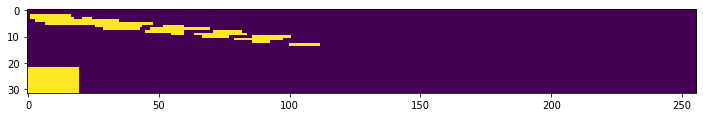

In [155]:
plt.figure(figsize=[12,3])
plt.imshow(np.zeros([32,256]))
coordinates = []
for r in range(bin_image.shape[0]):
    for c in range(bin_image.shape[1]):
        coordinates.append([r,c])
coordinates = np.array(coordinates)
rois = []
meanImg_b0 = []
rois = []
for contour in contours:
    if contour.shape[0]>thre:
        p = Path(contour)
        roi = p.contains_points(coordinates)
        roi = roi.reshape(32,256)
        f0 = np.sum(roi*mean_image)/np.sum(roi)
        rois.append(roi)
        meanImg_b0.append(roi*mean_image)


x = np.arange(0, 20)
y = np.arange(22, 32)
xv, yv = np.meshgrid(x, y)
mask = np.zeros(mean_image.shape)
mask[yv.flatten().astype(np.int), xv.flatten().astype(np.int)] = 1
rois.append(mask) # Add mask (fb)
meanImg_b0.append(rois[-1]*mean_image) # Add mask (fb)
rois_all = np.sum(rois,axis=0)      
        
plt.imshow(rois_all)
meanImg_b0 = np.sum(meanImg_b0,axis=0)
# plt.colorbar()
plt.show()


- Show ROIs with raw value

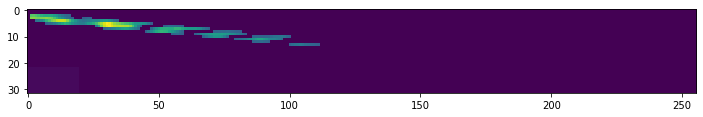

In [156]:
plt.figure(figsize=[12,3])
plt.imshow(meanImg_b0)
# plt.colorbar()
plt.show()


### Plot:
- dFF traces

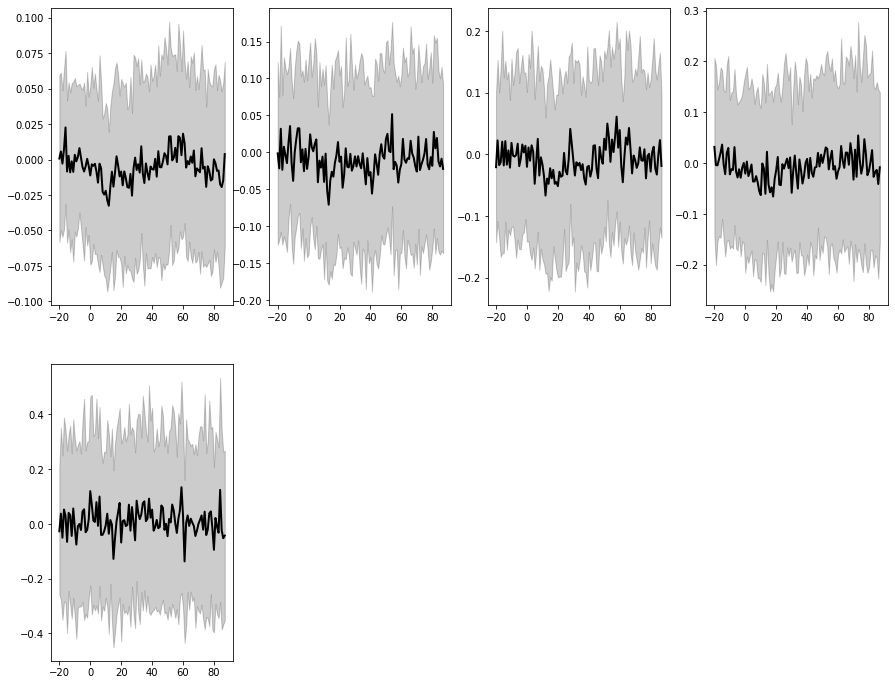

In [157]:
bl_frames = 20
frames_interval = f_tstamp[1]-f_tstamp[0]
total_frames = int((pulse_duration + interval)/frames_interval) + bl_frames

fig = plt.figure(figsize=(15,12))
dff_all = []
raw_all = []
for roi_no in range(len(rois)-1): # To exclude fb
    data_raw = []
    data_dff = []
    for i in range(len(indexes)):
        f0 = (np.sum(rois[roi_no]*np.mean(imgFile[indexes[i]-20:indexes[i],:,:],axis=0)))/np.sum(rois[roi_no])
        fb = (np.sum(rois[-1]*np.mean(imgFile[indexes[i]-20:indexes[i],:,:],axis=0)))/np.sum(rois[-1])
        seg_raw = []
        seg_dff = []
        for frame in range(total_frames):
            f = np.sum(rois[roi_no]*imgFile[indexes[i]-20+frame,:,:])/np.sum(rois[roi_no])
            dff = (f-f0)/(f0-fb)
            seg_raw.append(f)
            seg_dff.append(dff)
        data_raw.append(seg_raw)
        data_dff.append(seg_dff)
    dff_mean = np.mean(data_dff, axis=0)
    dff_std = np.std(data_dff, axis=0)
    raw_mean = np.mean(data_raw, axis=0)
    raw_std = np.std(data_raw, axis=0)
    x = np.arange(total_frames)-bl_frames
    ax = fig.add_subplot(len(rois)/4+1,4,roi_no+1)
    ax.plot(x, dff_mean, color = 'k', lw=2)
    ax.fill_between(x, dff_mean - dff_std, dff_mean + dff_std, color='k', alpha=0.2)
#     ax.plot(x, raw_mean, color = 'k', lw=2)
#     ax.fill_between(x, raw_mean - raw_std, raw_mean + raw_std, color='k', alpha=0.2)
    dff_all.append(dff_mean)
    raw_all.append(raw_mean)
plt.show()


- All ROIs average

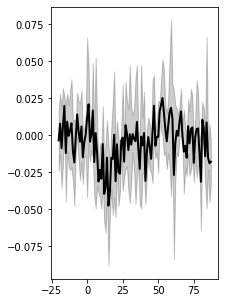

In [158]:
dff_all_mean = np.mean(dff_all,axis=0)
dff_all_std = np.std(dff_all,axis=0)
fig,(ax) = plt.subplots(1,1,figsize=[3,5])
x = np.arange(total_frames)-bl_frames
ax.plot(x, dff_all_mean, color = 'k', lw=2)
ax.fill_between(x, dff_all_mean - dff_all_std, dff_all_mean + dff_all_std, color='k', alpha=0.2)
plt.show()


### Get whole trace

In [159]:
dff_all = []
for roi_no in range(len(rois)-1): # To exclude fb
    data_raw = []
    for i in range(imgFile.shape[0]):
        f0 = (np.sum(rois[roi_no]*imgFile[i,:,:]))/np.sum(rois[roi_no])
        data_raw.append(f0)
    dff_all.append(data_raw)    
    
    

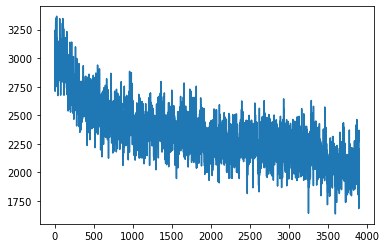

In [160]:
plt.plot(dff_all[0])
plt.show()


### Plot power spectrum

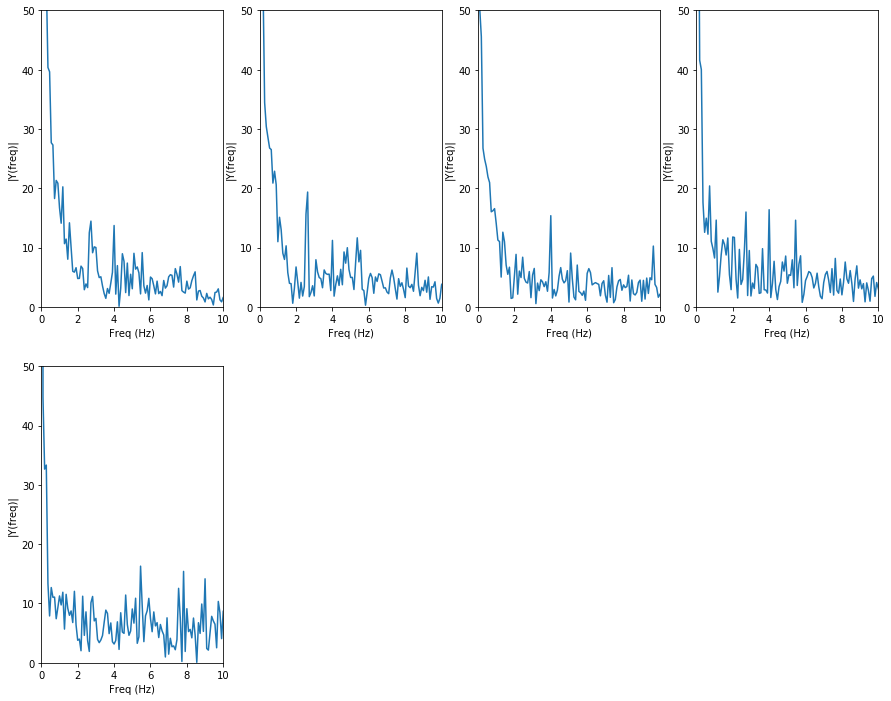

In [161]:
fig = plt.figure(figsize=(15,12))

Fs = 1000/frames_interval;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,10.5,Ts) # time vector

for roi_no in range(len(rois)-1): # To exclude fb
    y = np.array(dff_all[roi_no])

    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    ax = fig.add_subplot(len(rois)/4+1,4,roi_no+1)
    ax.plot(frq,abs(Y)) # plotting the spectrum
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('|Y(freq)|')
    ax.set_ylim([0,50])
    ax.set_xlim([0,10])

plt.show()


### Plot selected ROIs mean

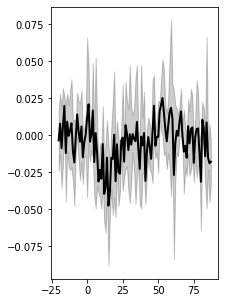

In [162]:
roi_sel = [0,1,2,3]
dff_sel = []
for roi in(roi_sel):
    dff_sel.append(dff_all[roi])
    

dff_sel_mean = np.mean(dff_sel,axis=0)
dff_sel_std = np.std(dff_sel,axis=0)
fig,(ax) = plt.subplots(1,1,figsize=[3,5])
x = np.arange(total_frames)-bl_frames
ax.plot(x, dff_all_mean, color = 'k', lw=2)
ax.fill_between(x, dff_all_mean - dff_all_std, dff_all_mean + dff_all_std, color='k', alpha=0.2)
plt.show()


In [141]:
imsave('/Users/zhengj10/Desktop/test.tif', imgFile)

//anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /Users/zhengj10/Desktop/test.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
